In [1]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras.backend as K
import matplotlib.pyplot as plt
from datetime import datetime

2024-12-01 12:21:43.699843: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 12:21:43.742194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 12:21:44.347910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Path configurations
BASE_PATH = "/home/user/adithyaes/dataset/isles2022_png"
AUG_PATH = "/home/user/adithyaes/dataset/isles2022_png_aug"
INPUT_PATH = os.path.join(BASE_PATH, "input")
MASK_PATH = os.path.join(BASE_PATH, "mask")
AUG_INPUT_PATH = os.path.join(AUG_PATH, "input")
AUG_MASK_PATH = os.path.join(AUG_PATH, "mask")
OUTPUT_DIRECTORY = "./output/ISLESfolder"
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

In [3]:
# Model parameters
IMG_SIZE = 112
BATCH_SIZE = 4
LEARNINGRATE = 0.001
EPOCHS = 10 # 100
EARLYSTOPPING = 40
scaler = MinMaxScaler(feature_range=(-1, 1))

In [4]:
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    return (intersection + 0.1) / (union - intersection + 0.1)

def dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1 - dice_coeff(y_true, y_pred))

In [5]:
def conv_block(inp, filters):
    x = Conv2D(filters, 3, padding='same', use_bias=False)(inp)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def attention_gate(x, g, filters):
    g1 = Conv2D(filters, 1)(g)
    x1 = Conv2D(filters, 1)(x)
    out = Activation('relu')(add([g1, x1]))
    out = Conv2D(1, 1, activation='sigmoid')(out)
    return multiply([x, out])

In [6]:
def get_case_ids(path):
    files = sorted([f for f in os.listdir(path) if f.endswith('.png')])
    return sorted(list({f.split('_')[1] for f in files}))

def load_and_preprocess(file_path, is_mask=False):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    if not is_mask:
        img = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
    else:
        img = img / 255.0
    return img

In [7]:
def plot_training_metrics(history):
    """
    Visualize training and validation metrics over epochs
    """
    metrics = ['loss', 'dice_coeff', 'iou', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Over Epochs', fontsize=16)

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        ax.plot(history.history[metric], label=f'Training {metric}')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        ax.set_title(f'{metric.replace("_", " ").title()} vs Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.legend(loc='best')
        ax.grid(True)

    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'training_metrics_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, aug_ids=None, batch_size=BATCH_SIZE, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.aug_ids = aug_ids if aug_ids is not None else []
        self.all_ids = list_IDs + self.aug_ids
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_ids = [self.all_ids[k] for k in indexes]
        return self.__data_generation(batch_ids)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X, y = [], []
        for case_id in batch_ids:
            is_aug = case_id in self.aug_ids
            input_dir = AUG_INPUT_PATH if is_aug else INPUT_PATH
            mask_dir = AUG_MASK_PATH if is_aug else MASK_PATH

            input_files = sorted([f for f in os.listdir(input_dir)
                                if f.startswith(f'slice_{case_id}') and f.endswith('.png')])

            for f in input_files:
                img_path = os.path.join(input_dir, f)
                mask_path = os.path.join(mask_dir, f)

                X.append(load_and_preprocess(img_path))
                y.append(load_and_preprocess(mask_path, is_mask=True))

        return np.expand_dims(np.array(X), -1), np.array(y)

In [9]:
def create_model():
    inputs = Input((IMG_SIZE, IMG_SIZE, 1))

    # Encoder
    x = conv_block(inputs, 32)
    skip1 = x
    x = MaxPooling2D()(x)

    x = conv_block(x, 64)
    skip2 = x
    x = MaxPooling2D()(x)

    x = conv_block(x, 128)
    skip3 = x
    x = MaxPooling2D()(x)

    x = conv_block(x, 256)
    skip4 = x
    x = MaxPooling2D()(x)

    # Bridge
    x = conv_block(x, 512)

    # Decoder with attention
    x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = attention_gate(skip4, x, 256)
    x = concatenate([x, skip4])
    x = conv_block(x, 256)

    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = attention_gate(skip3, x, 128)
    x = concatenate([x, skip3])
    x = conv_block(x, 128)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = attention_gate(skip2, x, 64)
    x = concatenate([x, skip2])
    x = conv_block(x, 64)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = attention_gate(skip1, x, 32)
    x = concatenate([x, skip1])
    x = conv_block(x, 32)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNINGRATE),
        loss=dice_loss,
        metrics=['accuracy', dice_coeff, iou]
    )

    return model

In [10]:
# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Data preparation
case_ids = get_case_ids(INPUT_PATH)
aug_case_ids = get_case_ids(AUG_INPUT_PATH) if os.path.exists(AUG_INPUT_PATH) else []

train_ids, test_ids = train_test_split(case_ids, test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)

print(f"\nDataset Distribution:")
print(f"Train: {len(train_ids)}, Validation: {len(val_ids)}")
print(f"Test: {len(test_ids)}, Augmented: {len(aug_case_ids)}\n")

# Initialize generators
train_gen = DataGenerator(train_ids, aug_ids=aug_case_ids)
val_gen = DataGenerator(val_ids, shuffle=False)
test_gen = DataGenerator(test_ids, shuffle=False)

# Create and compile model
model = create_model()
print("\nModel Architecture Summary:")
model.summary()

# Training callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_dice_coeff', mode='max',
                   save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=EARLYSTOPPING,
                 restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

# Model training
print("\nInitiating Model Training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    workers=4,
    use_multiprocessing=True
)


Dataset Distribution:
Train: 160, Validation: 40
Test: 50, Augmented: 63



2024-12-01 12:21:45.526561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14394 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6



Model Architecture Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                

2024-12-01 12:21:46.337808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-01 12:21:50.331733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-12-01 12:21:56.541665: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x4aa1700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-01 12:21:56.541693: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-01 12:21:56.545681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-01 12:21:56.691652: I ./ten

 2/55 [>.............................] - ETA: 13:20 - loss: 1.6169 - accuracy: 0.5609 - dice_coeff: 0.0022 - iou: 0.0011

2024-12-01 12:22:37.471358: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 12:22:37.652136: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 12:22:37.652201: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 12:22:38.701396: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

 6/55 [==>...........................] - ETA: 14:05 - loss: 1.5210 - accuracy: 0.8275 - dice_coeff: 0.0081 - iou: 0.0041

2024-12-01 12:23:49.422273: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-01 12:23:49.422320: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


55/55 [==============================] - ETA: 0s - loss: 1.3171 - accuracy: 0.9740 - dice_coeff: 0.0174 - iou: 0.0088 

2024-12-01 12:33:08.922834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_dice_coeff improved from -inf to 0.00850, saving model to best_model.h5
55/55 [==============================] - 703s 12s/step - loss: 1.3171 - accuracy: 0.9740 - dice_coeff: 0.0174 - iou: 0.0088 - val_loss: 1.2985 - val_accuracy: 0.9961 - val_dice_coeff: 0.0085 - val_iou: 0.0043 - lr: 0.0010
Epoch 2/10
27/55 [=============>................] - ETA: 2:37 - loss: 1.1852 - accuracy: 0.9932 - dice_coeff: 0.0293 - iou: 0.0150

2024-12-01 12:36:23.380879: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


55/55 [==============================] - ETA: 0s - loss: 1.1215 - accuracy: 0.9933 - dice_coeff: 0.0480 - iou: 0.0248
Epoch 2: val_dice_coeff did not improve from 0.00850
55/55 [==============================] - 272s 5s/step - loss: 1.1215 - accuracy: 0.9933 - dice_coeff: 0.0480 - iou: 0.0248 - val_loss: 1.1125 - val_accuracy: 0.9961 - val_dice_coeff: 0.0074 - val_iou: 0.0037 - lr: 0.0010
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.9413 - accuracy: 0.9929 - dice_coeff: 0.1223 - iou: 0.0666
Epoch 3: val_dice_coeff improved from 0.00850 to 0.01137, saving model to best_model.h5
55/55 [==============================] - 206s 4s/step - loss: 0.9413 - accuracy: 0.9929 - dice_coeff: 0.1223 - iou: 0.0666 - val_loss: 1.0321 - val_accuracy: 0.9961 - val_dice_coeff: 0.0114 - val_iou: 0.0057 - lr: 0.0010
Epoch 4/10
55/55 [==============================] - ETA: 0s - loss: 0.7718 - accuracy: 0.9939 - dice_coeff: 0.2534 - iou: 0.1514
Epoch 4: val_dice_coeff improved from 0.0

In [11]:
def visualize_specific_case(model, case_id, input_path=INPUT_PATH, mask_path=MASK_PATH):
    """
    Visualize predictions for a specific case ID from the dataset.
    
    Parameters:
    -----------
    model : tensorflow.keras.Model
        Trained model for prediction
    case_id : int
        Case ID to visualize (1-250)
    input_path : str
        Path to input images
    mask_path : str
        Path to mask images
    """
    # Format case_id to match filename pattern
    case_str = f"{case_id:03d}"
    
    # Get all slices for the specified case
    input_files = sorted([f for f in os.listdir(input_path) 
                         if f.startswith(f'slice_{case_str}_') and f.endswith('.png')])
    
    if not input_files:
        raise ValueError(f"No files found for case {case_id}")
    
    # Load and preprocess all slices
    X = []
    Y = []
    for f in input_files:
        img_path = os.path.join(input_path, f)
        mask_path_file = os.path.join(mask_path, f)
        
        X.append(load_and_preprocess(img_path))
        Y.append(load_and_preprocess(mask_path_file, is_mask=True))
    
    X = np.expand_dims(np.array(X), -1)
    Y = np.array(Y)
    
    # Generate predictions
    predictions = model.predict(X)
    predictions_thresholded = predictions > 0.1
    
    # Create output directory for this case
    case_output_dir = os.path.join(OUTPUT_DIRECTORY, f'case_{case_str}')
    os.makedirs(case_output_dir, exist_ok=True)
    
    # Calculate metrics for all slices
    slice_metrics = []
    
    # Visualize results for each slice
    for idx in range(len(X)):
        dice = dice_score(Y[idx], predictions_thresholded[idx, :, :, 0])
        iou_val = iou(Y[idx], predictions_thresholded[idx, :, :, 0])
        slice_metrics.append((dice, iou_val))
        
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(X[idx, :, :, 0], cmap='gray')
        plt.title('Input DWI')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(1, 4, 2)
        plt.imshow(Y[idx], cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Predicted probability map
        plt.subplot(1, 4, 3)
        plt.imshow(predictions[idx, :, :, 0], cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        
        # Thresholded prediction
        plt.subplot(1, 4, 4)
        plt.imshow(predictions_thresholded[idx, :, :, 0], cmap='gray')
        plt.title('Thresholded')
        plt.axis('off')
        
        plt.suptitle(f'Case {case_id} - Slice {idx+1}\nDice: {dice:.3f}, IoU: {iou_val:.3f}')
        
        # Save individual slice visualization
        plt.savefig(os.path.join(case_output_dir, f'slice_{idx+1}.png'))
        plt.close()
    
    # Generate and save metrics summary
    mean_dice = np.mean([m[0] for m in slice_metrics])
    mean_iou = np.mean([m[1] for m in slice_metrics])
    
    metrics_summary = f"""Case {case_id} Analysis Summary
    -------------------------
    Total Slices: {len(X)}
    Mean Dice Score: {mean_dice:.3f}
    Mean IoU Score: {mean_iou:.3f}
    -------------------------"""
    
    with open(os.path.join(case_output_dir, 'metrics_summary.txt'), 'w') as f:
        f.write(metrics_summary)
    
    return mean_dice, mean_iou

# Example usage:
# After model training, you can visualize specific cases:
def analyze_test_cases(model, case_ids):
    """
    Analyze multiple test cases and generate comprehensive visualizations.
    
    Parameters:
    -----------
    model : tensorflow.keras.Model
        Trained model for prediction
    case_ids : list
        List of case IDs to analyze
    """
    results = {}
    
    for case_id in case_ids:
        print(f"\nAnalyzing Case {case_id}...")
        try:
            mean_dice, mean_iou = visualize_specific_case(model, case_id)
            results[case_id] = {
                'dice': mean_dice,
                'iou': mean_iou
            }
            print(f"Case {case_id} - Mean Dice: {mean_dice:.3f}, Mean IoU: {mean_iou:.3f}")
        except Exception as e:
            print(f"Error processing case {case_id}: {str(e)}")
    
    return results

# Usage example:
# Specify cases to analyze
# analyze_test_cases(model, [19, 20, 21])  # Analyze cases 19, 20, and 21
# Or analyze a single case:
# visualize_specific_case(model, 19)  # Analyze case 19

In [12]:
results = analyze_test_cases(model, [19, 20, 21])


Analyzing Case 19...
Error processing case 19: No files found for case 19

Analyzing Case 20...
Error processing case 20: No files found for case 20

Analyzing Case 21...
Error processing case 21: No files found for case 21


In [13]:
def visualize_augmented_samples(train_gen, num_samples=3):
    """
    Display augmented samples with their corresponding masks
    """
    plt.figure(figsize=(15, 10))

    for batch_x, batch_y in train_gen:
        aug_images = batch_x
        aug_masks = batch_y
        break

    for idx in range(min(num_samples, len(aug_images))):
        # Augmented Image
        plt.subplot(2, num_samples, idx + 1)
        plt.imshow(aug_images[idx, :, :, 0], cmap='gray')
        plt.title(f'Augmented Image {idx+1}')
        plt.axis('off')

        # Corresponding Mask
        plt.subplot(2, num_samples, num_samples + idx + 1)
        plt.imshow(aug_masks[idx], cmap='gray')
        plt.title(f'Augmented Mask {idx+1}')
        plt.axis('off')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'augmentation_samples_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()

def visualize_segmentation_results(model, test_gen, num_samples=3):
    for batch_x, batch_y in test_gen:
        test_images = batch_x
        true_masks = batch_y
        break

    predictions = model.predict(test_images)
    predictions = (predictions > 0.5).astype(np.float32)  # Change to float32 instead of uint8

    plt.figure(figsize=(15, 20))

    for idx in range(min(num_samples, len(test_images))):
        plt.subplot(num_samples, 2, 2*idx + 1)
        plt.imshow(test_images[idx, :, :, 0], cmap='gray')
        plt.title(f'Input DWI Image {idx+1}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*idx + 2)
        plt.imshow(predictions[idx, :, :, 0], cmap='gray')
        dice_score = float(dice_coeff(true_masks[idx], predictions[idx, :, :, 0]))
        iou_score = float(iou(true_masks[idx], predictions[idx, :, :, 0]))
        plt.title(f'Predicted Segmentation {idx+1}\n' +
                 f'Dice: {dice_score:.4f}, IoU: {iou_score:.4f}')
        plt.axis('off')

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIRECTORY, f'segmentation_results_{timestamp}.png'),
                bbox_inches='tight', dpi=300)
    plt.close()

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def visualize_prediction(model, test_gen, sample_idx=0):
    # Get a batch of test data
    X_test, y_test = test_gen[sample_idx]
    
    # Make predictions
    predictions = model.predict(X_test)
    predictions_thresholded = predictions > 0.1
    
    # Create output directory
    output_directory = './output/ISLESfolder/predictions'
    os.makedirs(output_directory, exist_ok=True)
    
    for idx in range(len(X_test)):
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(X_test[idx, :, :, 0], cmap='gray')
        plt.title('Input Image')
        
        # Ground truth mask
        plt.subplot(1, 4, 2)
        plt.imshow(y_test[idx], cmap='gray')
        plt.title('Ground Truth')
        
        # Predicted probability map
        plt.subplot(1, 4, 3)
        plt.imshow(predictions[idx, :, :, 0], cmap='gray')
        plt.title('Prediction')
        
        # Thresholded prediction
        plt.subplot(1, 4, 4)
        plt.imshow(predictions_thresholded[idx, :, :, 0], cmap='gray')
        plt.title('Thresholded')
        
        # Calculate metrics
        dice = dice_coeff(y_test[idx], predictions_thresholded[idx, :, :, 0])
        iou_score = iou(y_test[idx], predictions_thresholded[idx, :, :, 0])
        plt.suptitle(f'Slice {idx} - Dice: {dice:.3f}, IoU: {iou_score:.3f}')
        
        # Save plot
        plt.savefig(os.path.join(output_directory, f'prediction_{idx}.png'))
        plt.close()

def plot_training_history(history):
    metrics = ['loss', 'dice_coeff', 'accuracy']
    titles = ['Loss', 'Dice Coefficient', 'Accuracy']
    
    plt.figure(figsize=(20, 5))
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Training {title}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {title}')
        plt.title(f'Training and Validation {title}')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('./output/ISLESfolder/training_history.png')
    plt.close()

def visualize_model_architecture(model):
    plot_model(model, 
              to_file='./output/ISLESfolder/model_architecture.png',
              show_shapes=True,
              show_layer_names=True,
              rankdir='TB',
              dpi=70)

10/10 [==============================] - 2s 86ms/step


InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a bool tensor [Op:Mul]

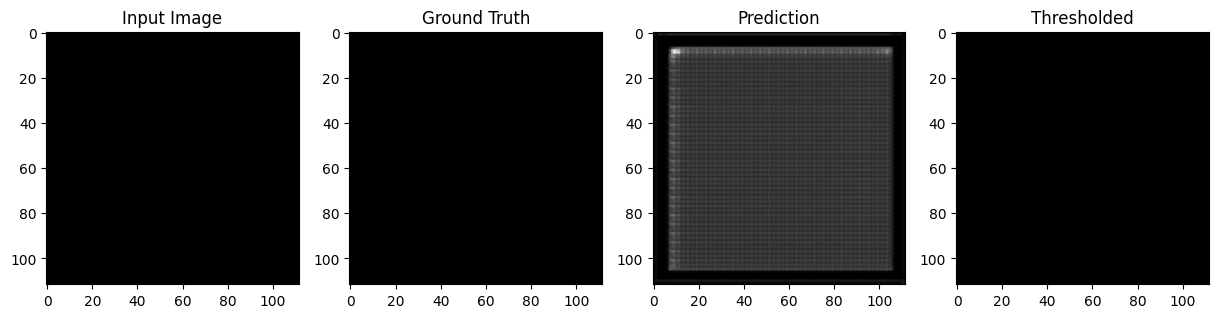

In [15]:
# Generate visualizations
visualize_prediction(model, test_gen)
plot_training_history(history)
visualize_model_architecture(model)

In [ ]:
pred_wt=model.predict(X)

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(pred_wt[31,:,:,:],cmap='gray')

In [ ]:
y_pred_thresholded = pred_wt > 0.1

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.imshow(y_pred_thresholded[31,:,:,:],cmap='gray')

In [ ]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    total = np.sum(y_true) + np.sum(y_pred)
    dice = (2 * intersection +1 ) / (total + 1)  # Adding a small epsilon to avoid division by zero
    #dice = np.mean(dice)
    dice = round(dice, 3)
    return dice

def iou(y_true,y_pred):
    intersec = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred)
    iou = (intersec + 1) / (union- intersec + 1)
    iou = round(iou, 3)
    return iou

In [ ]:
# Specify the directory to save the plot images
output_directory = './output/ISLESfolder'
os.makedirs(output_directory, exist_ok=True)

# Plot each slice along with the original mask and predicted mask
for i in range(5,60):
    plt.figure(figsize=(15, 5))

    # Plot the original image
    plt.subplot(1, 4, 1)
    plt.imshow(dwi_image[:,:,i], cmap='gray')
    plt.title('Input Slice')

    # Plot the original mask
    plt.subplot(1, 4, 2)
    plt.imshow(mask_image[:,:,i], cmap='gray')
    plt.title('Original Mask')

    # Plot the predicted mask
    plt.subplot(1, 4, 3)
    plt.imshow(pred_wt[i,:,:,:], cmap='gray')
    plt.title('Predicted Mask')
    
    # Plot the predicted mask
    plt.subplot(1, 4, 4)
    plt.imshow(y_pred_thresholded[i,:,:,:], cmap='gray')
    plt.title('Thresholed Mask')

    #plt.suptitle(f"Slice: {i+1}")
    dice = dice_score(mask_image[:,:,i], y_pred_thresholded[i,:,:,:])
    Iou = iou(mask_image[:,:,i], y_pred_thresholded[i,:,:,:])
    plt.suptitle(f"Sample_19_Slice_00{i}  ,Dice Score:{dice}  ,IOU:{Iou}")
    #print(f'Dice Score: {dice}')
    #plt.savefig(f'plot_{i}.png')
    #plt.show()
        
    # Save the plot image in the output folder
    output_filename = f'Sample_19_Slice_00{i}.png'
    output_path = os.path.join(output_directory, output_filename)
    plt.savefig(output_path)
    plt.show()
    plt.close()  # Close the figure to release memory

In [ ]:
loss = att_unet_history.history['loss']
val_loss = att_unet_history.history['val_loss']

dice = att_unet_history.history['dice_coeff']
val_dice = att_unet_history.history['val_dice_coeff']

acc = att_unet_history.history['accuracy']
val_acc = att_unet_history.history['val_accuracy']

epochs_range = range(7)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, dice, label='Training Dice Coeff.')
plt.plot(epochs_range, val_dice, label='Validation Dice Coeff.')
plt.legend(loc='best')
plt.title('Training and Validation Dice Coefficient')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, acc, label='Training Accuracy.')
plt.plot(epochs_range, val_acc, label='Validation Accuracy.')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)